In [153]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

def compute_smooth_quadratic_coefficients(els,constant_slip):
    n_els = len(els.x1)
    # Design matrices (in x, y coordinates) for slip and slip gradients at each 3qn
    stride = 6
    slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(
        els, flag="node"
    )
    design_mat = np.zeros((n_els * stride, n_els * stride))

    # Set boundary conditions
    # Slip -or- slip gradients at the boundaries (we set them to 0 here)
    bc_vec = np.zeros((n_els * stride))
    bc_vec[0:2] = 0.0
    bc_vec[-2:] = 0.0
    bc_vec[2::stride] = constant_slip
    bc_vec[3::stride] = 0

    # Populate design matrix
    # Boundary nodes
    design_mat[0:2, :] = slip_mat[0:2]
    design_mat[-2:, :] = slip_mat[-2:, :]

    # Patch center nodes
    design_mat[2::stride, :] = slip_mat[2::stride, :]
    design_mat[3::stride, :] = slip_mat[3::stride, :]

    # Overlapping interior nodes (apply slip continuity and smoothness)
    # Slip continuity (x component)
    design_mat[4:-7:stride, :] = slip_mat[4:-7:stride, :] - slip_mat[6:-5:stride, :]

    # Slip continuity (x component)
    design_mat[5:-6:stride, :] = slip_mat[5:-6:stride, :] - slip_mat[7:-4:stride, :]

    # Smoothness
    # x component
    design_mat[6:-5:stride, :] = (
        slip_gradient_mat[4:-7:stride, :] - slip_gradient_mat[6:-5:stride, :]
    )
    # y component
    design_mat[7:-4:stride, :] = (
        slip_gradient_mat[5:-6:stride, :] - slip_gradient_mat[7:-4:stride, :]
    )

    # Solve for quadratic node coefficients (in local (s, n) coordinates)
    coeffs = np.linalg.inv(design_mat) @ bc_vec

    # Extract (s, n) components and store them in two separate vectors
    coeffs_s = np.zeros((3 * n_els))
    coeffs_n = np.zeros((3 * n_els))
    for i in range(n_els):
        coeffs_s[3 * i : 3 * (i + 1)] = coeffs[stride * i : stride * i + 3]
        coeffs_n[3 * i : 3 * (i + 1)] = coeffs[stride * i + 3 : stride * (i + 1)]
    
    return coeffs_s, coeffs_n

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
# Define a smooth slip function for a set of parameters (2 exponentials)
parameters = np.array([0.8, -0.3, 0.15, 0.2, 0.2, 0.25])
func_slip = lambda x, par: par[0] * np.exp(
    -((x - par[1]) ** 2) / 2 / (par[2] ** 2)
) + par[3] * np.exp(-((x - par[4]) ** 2) / 2 / (par[5] ** 2))

# Elastic parameters
mu = 1
nu = 0.25

# Fault geometry
a = 1  # fault half-length

# Observation point
npts = 450
x_obs = 0.999 * np.linspace(-a, a, npts).reshape(-1, 1)
y_obs = np.zeros_like(x_obs)

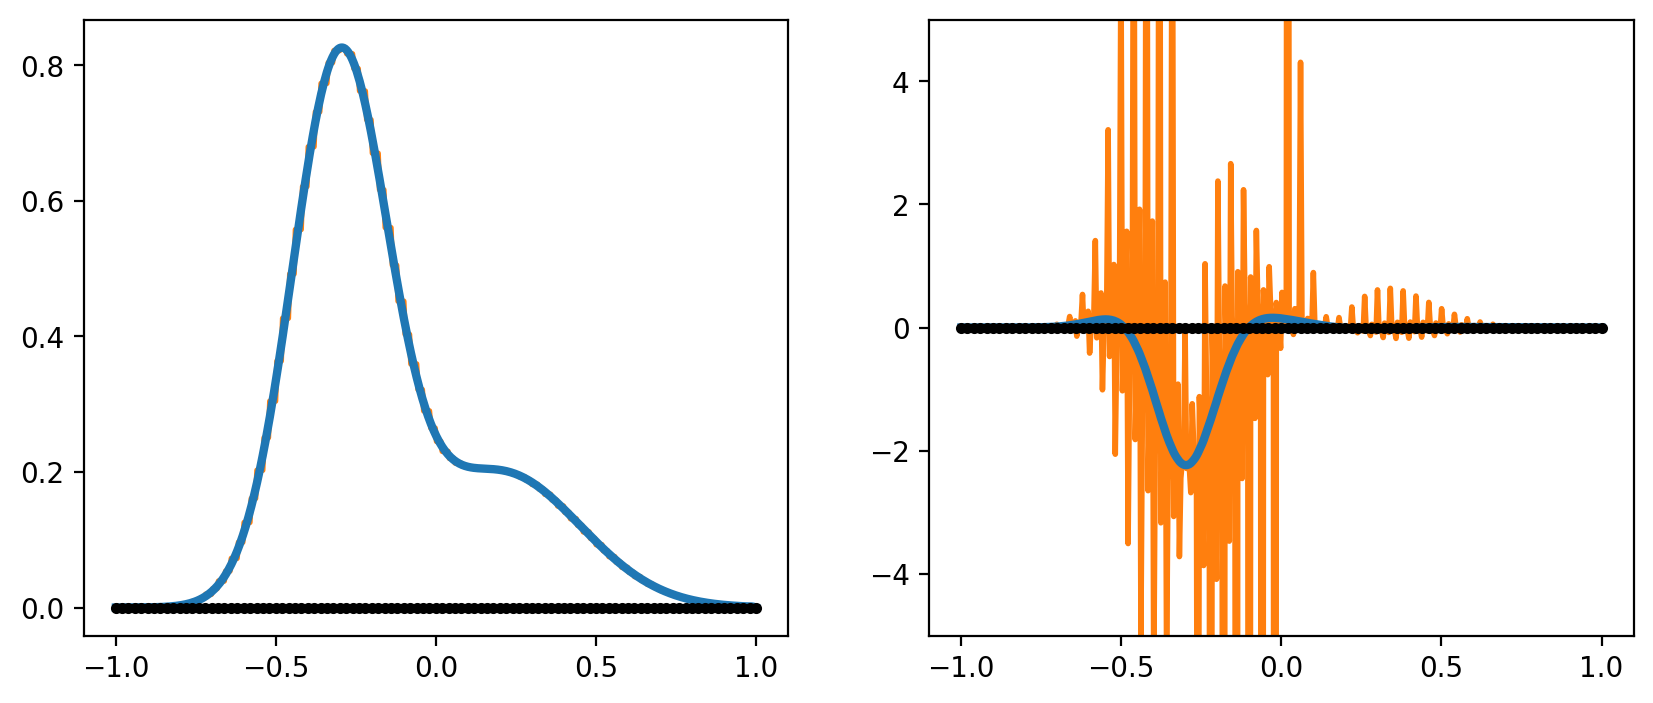

In [155]:
# n_els_vec = np.arange(5, 100, 5)
n_els_vec = np.round(np.logspace(1, 2, 20)).astype(int)

n_iter = len(n_els_vec)
nice_orange = "#ff7f0e"
nice_blue = "#1f77b4"

slipvec_constant = np.zeros_like(x_obs)
slipvec_quad = np.zeros_like(x_obs)
strain_energy_constant = np.zeros(n_iter)
strain_energy_quad = np.zeros(n_iter)

for i in range(n_iter):
    n_els = n_els_vec[i]
    x_vals = np.linspace(-a, a, n_els + 1)
    els = bemcs.initialize_els()
    els.x1 = x_vals[0:-1]
    els.y1 = np.zeros_like(els.x1)
    els.x2 = x_vals[1:]
    els.y2 = np.zeros_like(els.x1)
    bemcs.standardize_els_geometry(els)

    # Compute slip (constant)
    constant_slip = 0.5 * (
        func_slip(els.x1, parameters) + func_slip(els.x2, parameters)
    )
    # Compute shear and tensile stress kernels (constant slip kernels)
    kernels_s = bemcs.get_displacement_stress_kernel_constant(
        x_obs, y_obs, els, mu, nu, flag="shear"
    )
    kernels_n = bemcs.get_displacement_stress_kernel_constant(
        x_obs, y_obs, els, mu, nu, flag="normal"
    )
    _, _, _, _, sxy_constant = bemcs.coeffs_to_disp_stress(
        kernels_s, kernels_n, constant_slip, constant_slip * 0
    )
    # Get stair-step slip values
    for j in range(n_els):
        index = (x_obs >= els.x1[j]) & (x_obs < els.x2[j])
        slipvec_constant[index] = constant_slip[j]

    # Quadratic elements
    coeffs_s, coeffs_n = compute_smooth_quadratic_coefficients(els, constant_slip)

    # Compute shear and tensile stress kernels (quadratic kernels)
    kernels_s = bemcs.get_displacement_stress_kernel(
        x_obs, y_obs, els, mu, nu, flag="shear"
    )
    kernels_n = bemcs.get_displacement_stress_kernel(
        x_obs, y_obs, els, mu, nu, flag="normal"
    )
    _, _, _, _, sxy_quad = bemcs.coeffs_to_disp_stress(
        kernels_s, kernels_n, coeffs_s, coeffs_n
    )
    # Get slip values at x_obs
    for j in range(n_els):
        index = (x_obs >= els.x1[j]) & (x_obs < els.x2[j])
        design_mat = bemcs.slip_functions(
            x_obs[index] - els.x_centers[j], els.half_lengths[j]
        )
        slipvec_quad[index] = design_mat @ coeffs_s[3 * j : 3 * (j + 1)]

    strain_energy_constant[i] = np.sum(
        sxy_constant * slipvec_constant[:, 0] * (x_obs[1] - x_obs[0])
    )
    strain_energy_quad[i] = np.sum(
        sxy_quad * slipvec_quad[:, 0] * (x_obs[1] - x_obs[0])
    )

    if i >= n_iter - 1:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(x_obs, slipvec_constant, color=nice_orange, linewidth=2)
        plt.plot(x_obs, slipvec_quad, color=nice_blue, linewidth=3)
        plt.plot(x_vals, 0 * x_vals, "k.-")
        plt.subplot(1, 2, 2)
        plt.plot(
            x_obs, sxy_constant * slipvec_constant[:, 0], color=nice_orange, linewidth=2
        )
        plt.plot(x_obs, sxy_quad * slipvec_quad[:, 0], color=nice_blue, linewidth=3)
        plt.plot(x_vals, 0 * x_vals, "k.-")
        plt.ylim([-5, 5])
        plt.show()

# Strain energy convergence figure

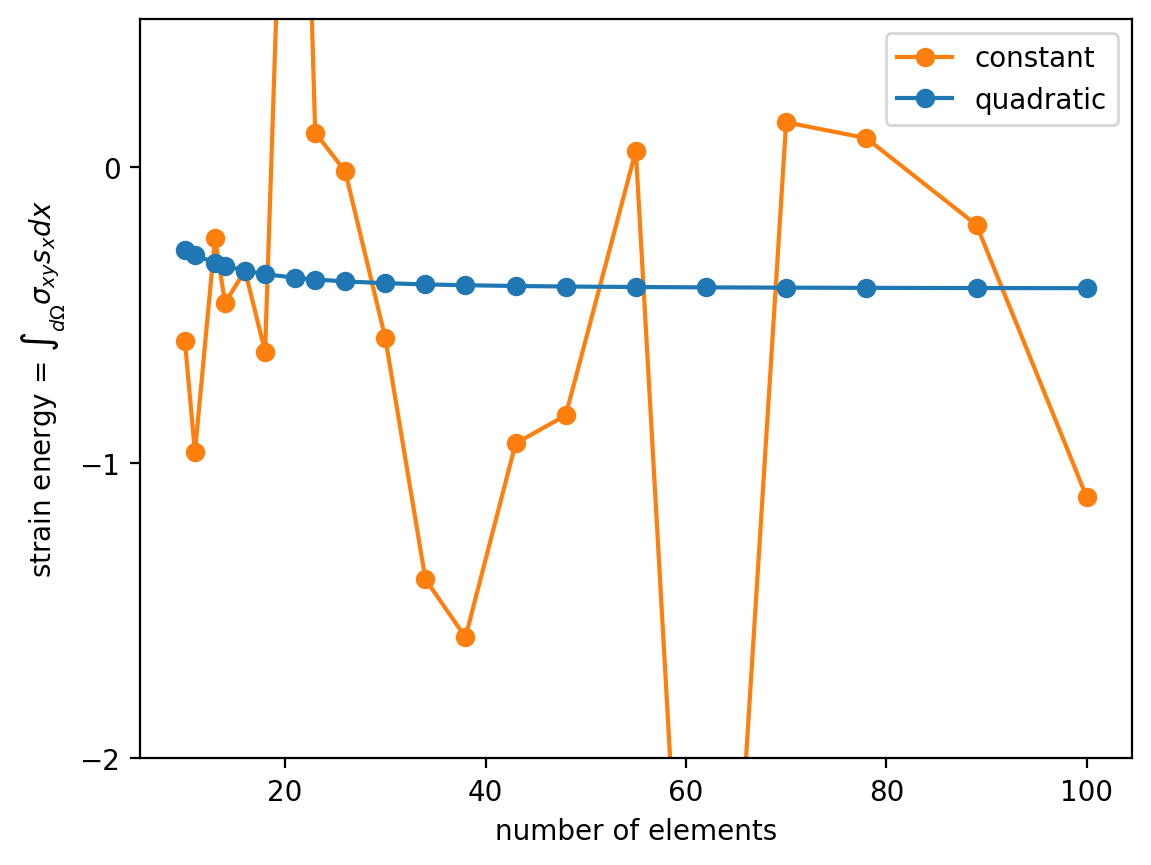

In [157]:
plt.figure()
plt.plot(n_els_vec, strain_energy_constant, "o-", color=nice_orange, label="constant")
plt.plot(n_els_vec, strain_energy_quad, "o-", color=nice_blue, label="quadratic")
plt.legend()
plt.ylim([-2, 0.5])
plt.yticks([-2, -1, 0])
plt.xlabel("number of elements")
plt.ylabel("strain energy = $\int_{d\Omega}\sigma_{xy} s_x dx$")
plt.savefig("convergence_comparison_strain_energy.pdf")
plt.show()